## Load Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it

%matplotlib inline

## Neurons as Logic Gates

The basic, classic activation function that we apply to neurons is a  sigmoid function:

$$
\sigma = \frac{1}{1 + e^{-x}}
$$

$\sigma$ ranges from (0, 1). When the input $x$ is negative, $\sigma$ is close to 0. When $x$ is positive, $\sigma$ is close to 1. At $x=0$, $\sigma=0.5$

In [2]:
def sigmoid(x):
    """Sigmoid function"""
    return 1.0 / (1.0 + np.exp(-x))

Plot the sigmoid function.

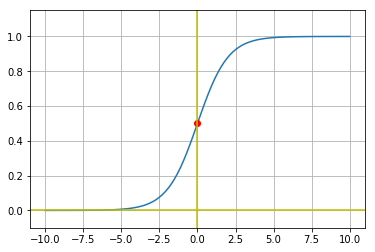

In [3]:
# Plot The sigmoid function
xs = np.linspace(-10, 10, num=100, dtype=np.float32)
activation = sigmoid(xs)

fig = plt.figure(figsize=(6,4))
plt.plot(xs, activation)
plt.plot(0,.5,'ro')

plt.grid(True, which='both')
plt.axhline(y=0, color='y')
plt.axvline(x=0, color='y')
plt.ylim([-0.1, 1.15]);

## Example Logic Gates

Some Utility Functions

In [4]:
def logic_gate(w1, w2, b):
    '''
    logic_gate is a function which returns a function.
    the returned function take two args and (hopefully)
    acts like a logic gate (and/or/not/etc.).  its behavior
    is determined by w1,w2,b.  a longer, better name would be
    make_twoarg_logic_gate_function
    '''
    def the_gate(x1, x2):
        return sigmoid(w1 * x1 + w2 * x2 + b)
    return the_gate

def test(gate):
    'Helper function to test out our weight functions.'
    for a, b in it.product(range(2), repeat=2):
        print("{}, {}: {}".format(a, b, np.round(gate(a, b))))

In [5]:
or_gate = logic_gate(20, 20, -10)
test(or_gate)

0, 0: 0.0
0, 1: 1.0
1, 0: 1.0
1, 1: 1.0


In [6]:
and_gate = logic_gate(20,20,-30)
test(and_gate)

0, 0: 0.0
0, 1: 0.0
1, 0: 0.0
1, 1: 1.0


In [7]:
nor_gate = logic_gate(-20,-20,20)
test(nor_gate)

0, 0: 1.0
0, 1: 0.0
1, 0: 0.0
1, 1: 0.0


In [8]:
nand_gate = logic_gate(-20,-20,30)
test(nand_gate)

0, 0: 1.0
0, 1: 1.0
1, 0: 1.0
1, 1: 0.0


In [9]:
# xor cannot be modeled by a single gate
def xor_gate(a, b):
    c = or_gate(a, b)
    d = nand_gate(a, b)
    return and_gate(c, d)
test(xor_gate)

0, 0: 0.0
0, 1: 1.0
1, 0: 1.0
1, 1: 0.0


Chaining together neurons can compose more complex models.

## Learning a Logic Gate

We can use TensorFlow to try and teach a model to learn the correct weights and bias by passing in our truth table as training data.

In [10]:
class TF_LogicGate:
    def __init__(s):  
        graph = tf.Graph()
        with graph.as_default():
            
            with tf.name_scope('inputs'):
                s.x1 = tf.placeholder(tf.float32, name='x1')
                s.x2 = tf.placeholder(tf.float32, name='x2')
                s.label = tf.placeholder(tf.float32, name='label')
                s.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
                
            with tf.name_scope('model'):
                s.w1 = tf.Variable(tf.random_normal([]), name='w1')
                s.w2 = tf.Variable(tf.random_normal([]), name='w2')
                s.b = tf.Variable(0.0, dtype=tf.float32, name='b')
                s.output = tf.nn.sigmoid(s.w1 * s.x1 + s.w2 * s.x2 + s.b)
                
            with tf.name_scope('loss'):
                s.loss = tf.reduce_mean(tf.square(s.output - s.label), name='mse')
                correct = tf.equal(tf.round(s.output), s.label)
                s.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
                
            with tf.name_scope('train'):
                s.train = tf.train.GradientDescentOptimizer(s.learning_rate).minimize(s.loss)
                
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
        
    def fit(s, train_dict):
        loss, acc, _ = s.session.run([s.loss, s.accuracy, s.train], feed_dict=train_dict)
        return loss, acc

    def predict(s, test_dict):
        return s.session.run([s.w1, s.w2, s.b, s.output], feed_dict=test_dict)

In [11]:
# set up train dict with the results of an and table
and_table = np.array([[0,0,0],
                      [1,0,0],
                      [0,1,0],
                      [1,1,1]])

logic_model = TF_LogicGate()

train_dict={logic_model.x1:    and_table[:,0],
            logic_model.x2:    and_table[:,1],
            logic_model.label: and_table[:,2], 
            logic_model.learning_rate: 0.5}

In [12]:
print("training")
for i in range(10000):
    loss, acc = logic_model.fit(train_dict)
    if i % 1000 == 0:
        print('loss: {}\taccuracy: {}'.format(loss, acc))
print('loss: {}\taccuracy: {}'.format(loss, acc))

training
loss: 0.3586837649345398	accuracy: 0.75
loss: 0.25024935603141785	accuracy: 0.75
loss: 0.24990376830101013	accuracy: 0.75
loss: 0.24955244362354279	accuracy: 0.75
loss: 0.24527019262313843	accuracy: 0.75
loss: 0.01359378919005394	accuracy: 1.0
loss: 0.005986128933727741	accuracy: 1.0
loss: 0.0037496830336749554	accuracy: 1.0
loss: 0.0027070427313447	accuracy: 1.0
loss: 0.0021094896364957094	accuracy: 1.0
loss: 0.001724359579384327	accuracy: 1.0


In [13]:
test_dict = {logic_model.x1: and_table[:,0], #[0.0, 1.0, 0.0, 1.0],
             logic_model.x2: and_table[:,1]} # [0.0, 0.0, 1.0, 1.0]}

In [14]:
print("testing")
w1_val, w2_val, b_val, out = logic_model.predict(test_dict)
print('Learned weight for w1:\t {}'.format(w1_val))
print('Learned weight for w2:\t {}'.format(w2_val))
print('Learned weight for bias: {}\n'.format(b_val))

testing

Learned weight for w1:	 5.930612564086914
Learned weight for w2:	 5.930612564086914
Learned weight for bias: -8.986828804016113



In [15]:
idx = 0
for i in [0, 1]:
    for j in [0, 1]:
        print('{}, {}: {}'.format(i, j, np.round(out[idx])))
        idx += 1

0, 0: 0.0
0, 1: 0.0
1, 0: 0.0
1, 1: 1.0


## Learning an XOR Gate

If we compose a two stage model, we can learn the XOR gate.

In [16]:
class XOR_Graph:
    def __init__(self):
        # Create an empty Graph to place our operations in
        xor_graph = tf.Graph()
        with xor_graph.as_default():
            # Placeholder inputs for our a, b, and label training data
            self.x1 = tf.placeholder(tf.float32)
            self.x2 = tf.placeholder(tf.float32)
            self.label = tf.placeholder(tf.float32)

            # A placeholder for our learning rate, so we can adjust it
            self.learning_rate = tf.placeholder(tf.float32)

            Var = tf.Variable; rn = tf.random_normal
            self.weights = [[Var(rn([])), Var(rn([]))],
                            [Var(rn([])), Var(rn([]))],
                            [Var(rn([])), Var(rn([]))]]
            self.biases = [Var(0.0, dtype=tf.float32),
                           Var(0.0, dtype=tf.float32),
                           Var(0.0, dtype=tf.float32)]
            sig1 = tf.nn.sigmoid(self.x1 * self.weights[0][0] + 
                                 self.x2 * self.weights[0][1] + 
                                 self.biases[0])
            sig2 = tf.nn.sigmoid(self.x1 * self.weights[1][0] + 
                                 self.x2 * self.weights[1][1] + 
                                 self.biases[1])
            self.output = tf.nn.sigmoid(sig1 * self.weights[2][0] + 
                                        sig2 * self.weights[2][1] + 
                                        self.biases[2])

            # We'll use the mean of squared errors as our loss function 
            self.loss = tf.reduce_mean(tf.square(self.output - self.label))
            
            # create a gradient descent training operation 
            # and an initialization operation
            gdo = tf.train.GradientDescentOptimizer
            self.train = gdo(self.learning_rate).minimize(self.loss)
            
            correct = tf.equal(tf.round(self.output), self.label)
            self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
            init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=xor_graph)
        self.sess.run(init)        

    def fit(self, train_dict):
        loss, acc, _ = self.sess.run([self.loss, self.accuracy, self.train], 
                                     train_dict)
        return loss, acc
        
    def predict(self, test_dict):
        all_trained = (self.weights[0] + [self.biases[0]] +
                       self.weights[1] + [self.biases[1]] +
                       self.weights[2] + [self.biases[2]])
        return self.sess.run(all_trained + [self.output], test_dict)

In [19]:
xor_table = np.array([[0,0,0],
                      [1,0,1],
                      [0,1,1],
                      [1,1,0]])

logic_model = XOR_Graph()

train_dict={logic_model.x1:    xor_table[:,0],
            logic_model.x2:    xor_table[:,1],
            logic_model.label: xor_table[:,2],
            logic_model.learning_rate: 0.5}

print("training")
for i in range(10000):
    loss, acc = logic_model.fit(train_dict)
    if i % 1000 == 0:
        print('loss: {}\taccuracy: {}'.format(loss, acc))
print('loss: {}\taccuracy: {}'.format(loss, acc))
            
print("testing")
test_dict = {logic_model.x1: xor_table[:,0], 
             logic_model.x2: xor_table[:,1]}
results = logic_model.predict(test_dict)
wb_lrn, predictions = results[:-1], results[-1]

print(wb_lrn)
wb_lrn = np.array(wb_lrn).reshape(3,3)

# combine the predictions with the inputs and clean up the data
# round it and convert to unsigned 8 bit ints
out_table = np.column_stack((xor_table[:,[0,1]], 
                             predictions)).round().astype(np.uint8)

print("results")
print('Learned weights/bias (L1):', wb_lrn[0])
print('Learned weights/bias (L2):', wb_lrn[1])
print('Learned weights/bias (L3):', wb_lrn[2])
print('Testing Table:')
print(out_table)
print("Correct?", np.allclose(xor_table, out_table))

training
loss: 0.29703134298324585	accuracy: 0.5
loss: 0.19086095690727234	accuracy: 0.75
loss: 0.06518189609050751	accuracy: 1.0
loss: 0.012577787972986698	accuracy: 1.0
loss: 0.006106953602284193	accuracy: 1.0
loss: 0.003922253847122192	accuracy: 1.0
loss: 0.0028577803168445826	accuracy: 1.0
loss: 0.0022355434484779835	accuracy: 1.0
loss: 0.001829994609579444	accuracy: 1.0
loss: 0.001545838313177228	accuracy: 1.0
loss: 0.0013363773468881845	accuracy: 1.0
testing
[6.870407, 6.8782935, -3.057933, -4.8926725, -4.8940954, 7.3238125, 7.7410927, 7.9591722, -11.53266]
results
Learned weights/bias (L1): [ 6.870407   6.8782935 -3.057933 ]
Learned weights/bias (L2): [-4.8926725 -4.8940954  7.3238125]
Learned weights/bias (L3): [  7.7410927   7.9591722 -11.53266  ]
Testing Table:
[[0 0 0]
 [1 0 1]
 [0 1 1]
 [1 1 0]]
Correct? True


# An Example Neural Network

So, now that we've worked with some primitive models, let's take a look at something a bit closer to what we'll work with moving forward:  an actual neural network.

The following model accepts a 100 dimensional input, has a hidden layer depth of 300, and an output layer depth of 50. We use a sigmoid activation function for the hidden layer.

In [18]:
nn1_graph = tf.Graph()
with nn1_graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 100])
    y = tf.placeholder(tf.float32, shape=[None])
    
    with tf.name_scope('hidden1'):
        w = tf.Variable(tf.truncated_normal([100, 300]), name='W')
        b = tf.Variable(tf.zeros([300]), name='b')
        z = tf.matmul(x, w) + b
        a = tf.nn.sigmoid(z)
    
    with tf.name_scope('output'):
        w = tf.Variable(tf.truncated_normal([300, 50]), name='W')
        b = tf.Variable(tf.zeros([50]), name='b')
        z = tf.matmul(a, w) + b
        output = z
    
    with tf.name_scope('global_step'):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        inc_step = tf.assign_add(global_step, 1, name='increment_step')
    
    with tf.name_scope('summaries'):
        for var in tf.trainable_variables():
            hist_summary = tf.summary.histogram(var.op.name, var)
        summary_op = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()